In [11]:
# DATA EXPLORATION
import os
from collections import Counter

data_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

class_counts = {}

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if os.path.isdir(class_folder):
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

total_images = sum(class_counts.values())

class_proportions = {class_name: count / total_images for class_name, count in class_counts.items()}

print("Class Proportions:")
for class_name, proportion in class_proportions.items():
    print(f"{class_name}: {proportion:.2f}")


Class Proportions:
tomato_fully_ripened: 0.01
tomato_half_ripened: 0.01
banana_overripe: 0.21
banana_rotten: 0.30
banana_unripe: 0.21
banana_ripe: 0.22
tomato_green: 0.05


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#resizing
IMG_SIZE = (224, 224)
#scaling and splits
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)#stratified splits for unbalanced data

trainData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',#uses label encoding
    shuffle=True,
    subset='training'
)

valData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/train/train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

testData = data.flow_from_directory(
    '/kaggle/input/fine-grained-fruit-quality-assessment/test',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.
Found 2484 images belonging to 1 classes.


**HELPER** **FUNCTIONS** (USED FOR ALL MODELS)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [14]:
# Title: Model Compilation
# Description: Compiles the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

def compile_model(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Title: Callback Generator
# Description: Returns a list of callbacks including EarlyStopping to prevent overfitting and ModelCheckpoint to save the best model weights during training.

from tensorflow.keras import callbacks # Import the callbacks module

def get_callbacks(model_name='baseline'):
    ##checkpoint = callbacks.ModelCheckpoint(
    ##    f'{model_name}_weights.h5',
    ##    save_best_only=True,
    ##    monitor='val_accuracy', mode='max')
    ###
    checkpoint = callbacks.ModelCheckpoint(
    f'{model_name}.weights.h5',  # <- changed _ to .
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    save_weights_only=True) # <- added this
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    return [early_stop, checkpoint]


In [16]:
# Title: Model Training Wrapper
# Description: Trains any given model using training and validation data, applying specified callbacks such as early stopping and checkpointing.

def train_model(model, trainData, valData, model_name='baseline', epochs=30):
    history = model.fit(
        trainData,
        validation_data=valData,
        epochs=epochs,
        callbacks=get_callbacks(model_name)
    )
    return history


In [17]:
# Title: Validation Evaluation & Reporting
# Description: Evaluates the model on the validation set, printing a classification report and displaying a confusion matrix.

def evaluate_model(model, valData, class_indices, model_name='Model'):
    val_preds = np.argmax(model.predict(valData), axis=1)
    y_true = valData.classes
    print(f"Evaluation Report for {model_name}")
    print(classification_report(y_true, val_preds, target_names=class_indices.keys()))
    plot_confusion_matrix(y_true, val_preds, class_indices)


In [18]:
# Title: Confusion Matrix Plotter
# Description: Plots a labeled heatmap confusion matrix comparing predicted vs true labels for easy visual analysis.

def plot_confusion_matrix(y_true, y_pred, class_indices):
    cm = confusion_matrix(y_true, y_pred)
    labels = list(class_indices.keys())
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [19]:
# Title: Training History Plotter
# Description: Plots training and validation accuracy/loss curves over epochs to visualize model performance trends.

def plot_training_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()


In [20]:
# Title: Test Prediction Exporter
# Description: Uses the trained model to predict labels for the test dataset and saves the results in a CSV file formatted for Kaggle submission.

def export_predictions(model, testData, output_filename="Team_CHP_5_predictions.csv"):
    test_preds = np.argmax(model.predict(testData), axis=1)
    filenames = testData.filenames
    df = pd.DataFrame({
        "ImageId": [os.path.basename(f) for f in filenames],
        "Label": test_preds
    })
    df.to_csv(output_filename, index=False)
    print(f"Predictions exported to {output_filename}")


BASELINE **CNN** Model

In [26]:
# BASELINE CNN MODEL

from tensorflow.keras import layers, models

def build_baseline_model(input_shape, num_classes):
    model = models.Sequential(name="Team_CHP_5_CNN_Baseline")
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Team_CHP_5_CNN_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - accuracy: 0.3681 - loss: 2.4383 - val_accuracy: 0.7300 - val_loss: 0.8163
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 61s 332ms/step - accuracy: 0.7099 - loss: 0.7620 - val_accuracy: 0.8464 - val_loss: 0.4998
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 61s 328ms/step - accuracy: 0.7901 - loss: 0.5592 - val_accuracy: 0.8356 - val_loss: 0.4143
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 60s 326ms/step - accuracy: 0.8110 - loss: 0.5039 - val_accuracy: 0.8566 - val_loss: 0.3746
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 62s 334ms/step - accuracy: 0.8428 - loss: 0.4192 - val_accuracy: 0.8674 - val_loss: 0.3619
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 59s 318ms/step - accuracy: 0.8523 - loss: 0.4084 - val_accuracy: 0.8843 - val_loss: 0.3208
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 63s 340ms/step - accuracy: 0.8627 - loss: 0.3664 - val_accuracy: 0.9032 - val_loss: 0.2636
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 60s 322ms/step - accuracy: 0.8597 - loss: 0

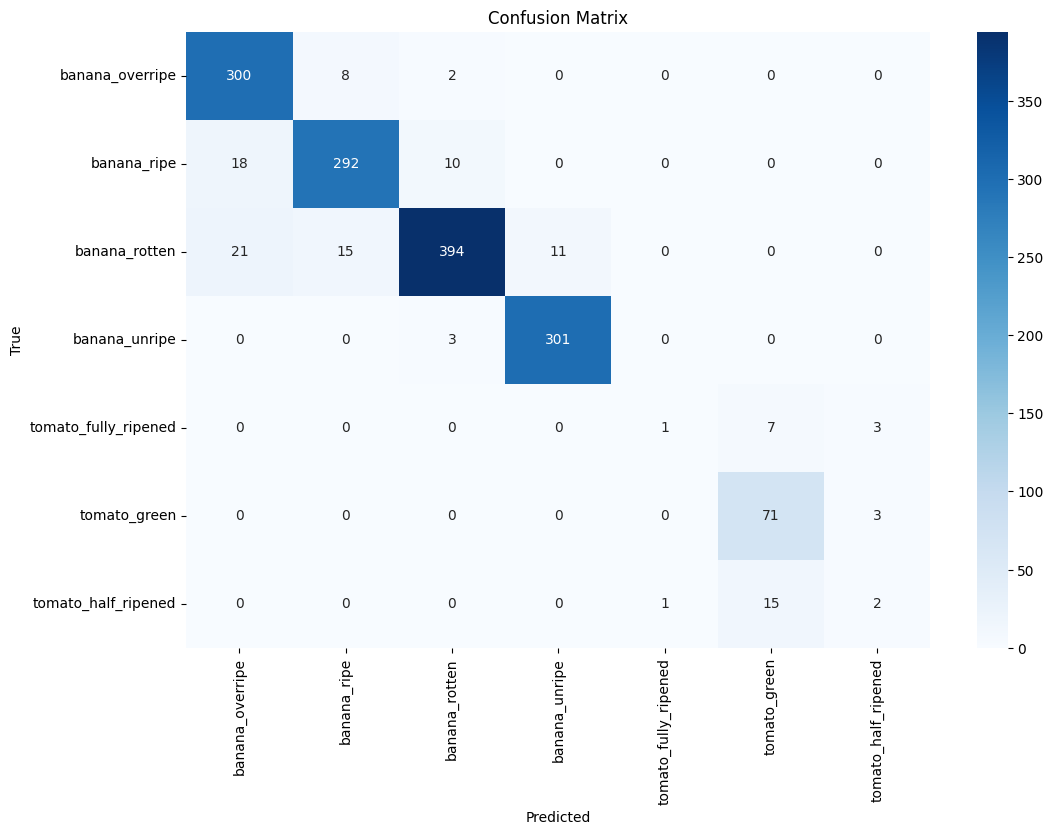

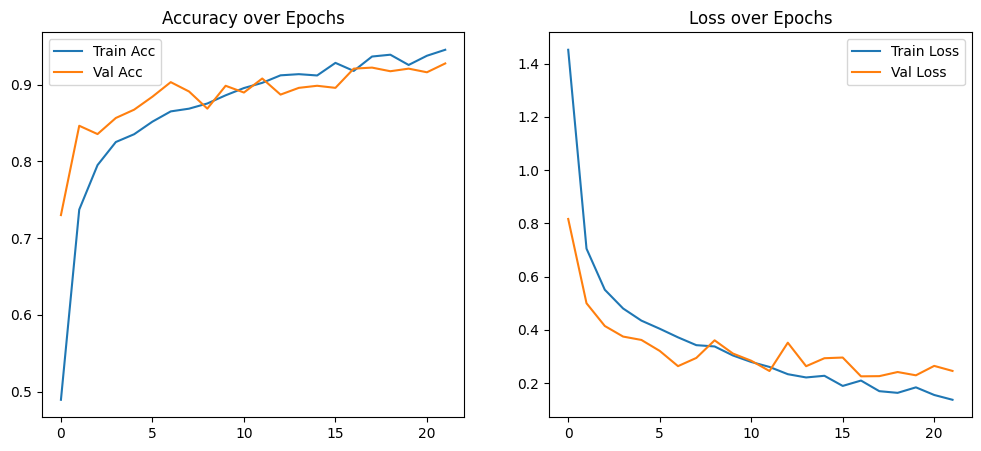

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step
Predictions exported to Team_CHP_5_predictions.csv


In [27]:
# RUN BASELINE CNN MODEL
baseline_model = build_baseline_model(input_shape=(224, 224, 3), num_classes=trainData.num_classes)
baseline_model = compile_model(baseline_model)
baseline_model.summary()
history = train_model(baseline_model, trainData, valData, model_name="Team_CHP_5_CNN", epochs=30)
evaluate_model(baseline_model, valData, class_indices=trainData.class_indices, model_name="Team_CHP_5_CNN")
plot_training_history(history)
export_predictions(baseline_model, testData, output_filename="Team_CHP_5_predictions.csv")

In [29]:
# Export Predictions
export_predictions(baseline_model, testData, output_filename="Team_CHP_5_predictions.csv")

# Save final files
baseline_model.save("/kaggle/working/Team_CHP_5_full_model.h5")
import shutil
shutil.move("Team_CHP_5_predictions.csv", "/kaggle/working/Team_CHP_5_predictions.csv")
shutil.move("Team_CHP_5_CNN.weights.h5", "/kaggle/working/Team_CHP_5_CNN.weights.h5")

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step
Predictions exported to Team_CHP_5_predictions.csv


'/kaggle/working/Team_CHP_5_CNN.weights.h5'

✅ Weights successfully loaded into the model.
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step
Evaluation Report for Reloaded CNN
                      precision    recall  f1-score   support

     banana_overripe       0.97      0.92      0.94       310
         banana_ripe       0.90      0.95      0.92       320
       banana_rotten       0.95      0.92      0.94       441
       banana_unripe       0.96      0.99      0.97       304
tomato_fully_ripened       0.00      0.00      0.00        11
        tomato_green       0.82      0.91      0.86        74
 tomato_half_ripened       0.32      0.39      0.35        18

            accuracy                           0.93      1478
           macro avg       0.70      0.73      0.71      1478
        weighted avg       0.92      0.93      0.93      1478



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


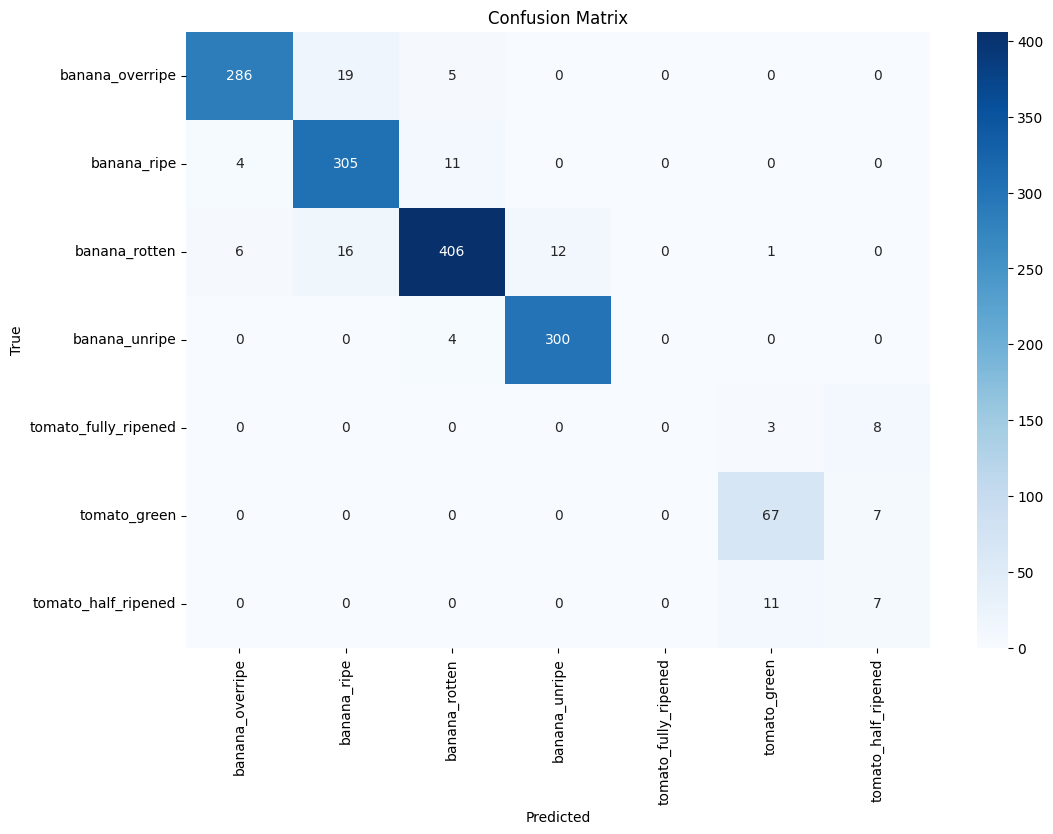

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step
Predictions exported to Team_CHP_5_test_predictions_from_weights.csv


In [ ]:
# RELOADING SAVED WEIGHTS & PREDICTING FOR PRACTICAL EXAM

# Rebuild the model architecture
reloaded_model = build_baseline_model(input_shape=(224, 224, 3), num_classes=trainData.num_classes)

# Load the saved weights
reloaded_model.load_weights('Team_CHP_5_CNN.weights.h5')
print("✅ Weights successfully loaded into the model.")

# Evaluate again (optional)
evaluate_model(reloaded_model, valData, trainData.class_indices, model_name="Reloaded CNN")

# Predict on the test set
export_predictions(reloaded_model, testData, output_filename="Team_CHP_5_test_predictions_from_weights.csv")


In [11]:
# Test Script
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
def export_predictions(model, testData, output_filename="Team_CHP_5_predictions.csv"):
    test_preds = np.argmax(model.predict(testData), axis=1)
    filenames = testData.filenames
    df = pd.DataFrame({
        "ImageId": [os.path.basename(f) for f in filenames],
        "Label": test_preds
    })
    df.to_csv(output_filename, index=False)
    print(f"Predictions exported to {output_filename}")

# Load the full saved model
reloaded_model = load_model("Team_CHP_5_full_model.h5")
print("✅ Full model loaded successfully.")

# Load the saved weights
reloaded_model.load_weights('Team_CHP_5_CNN.weights.h5')
print("✅ Weights successfully loaded into the model.")

# Evaluate again (optional)
# evaluate_model(reloaded_model, valData, trainData.class_indices, model_name="Reloaded CNN")
testData = '../testNew'

# Predict on the test set
export_predictions(reloaded_model, testData, output_filename="Team_CHP_5_test_predictions_from_full_model.csv")

✅ Full model loaded successfully.
✅ Weights successfully loaded into the model.


ValueError: Unrecognized data type: x=../testNew (of type <class 'str'>)